# Face Recognition 

## Importing Libraries

In [ ]:
%pip install matplotlib pandas numpy opencv-python scikit-learn opencv-contrib-python

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import StandardScaler

## Load Folder

In [ ]:
def load_images(data_path):
    images = []
    labels = []

    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            for image_filename in os.listdir(person_dir):
                if image_filename.endswith('.jpg'):
                    image_path = os.path.join(person_dir, image_filename)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    images.append(image)

                    labels.append(person_name)

    images = np.array(images)
    labels = np.array(labels)
    unique_labels = np.unique(labels)
    
    return {
        'data': images,
        'target': labels,
        'target_names': unique_labels
    }

dataset = load_images('./Data/')

In [ ]:
# BACKUP
lfw_dataset = dataset.copy()


print("Shape of images:", lfw_dataset['data'].shape)
print("Shape of labels:", lfw_dataset['target'].shape)
print("Unique labels:", lfw_dataset['target_names'].shape)

## Data Visualization

### Image Distribuition of Top 20 People

In [ ]:
target_counts = Counter(dataset['target'])

top_20_people = target_counts.most_common(20)

plt.figure(figsize=(12, 12))
plt.bar(*zip(*top_20_people))
plt.xlabel('Person')
plt.xticks(rotation=90)
plt.ylabel('Number of Images')
plt.title('Top 20 People')
plt.show()

### Histogram

In [ ]:
ranges = [(1, 1), (2, 5), (6, 10), (11, 20), (21, 30), (31, 80), (81, np.inf)]
labels = ['1', '2-5', '6-10', '11-20', '21-30', '31-80', '>81']

people_counts = [0] * len(ranges)
image_counts = [0] * len(ranges)

# For each person, increment the count for the appropriate range
for person, count in target_counts.items():
    for i, (min_count, max_count) in enumerate(ranges):
        if min_count <= count <= max_count:
            people_counts[i] += 1
            image_counts[i] += count
            break

# Calculate the percentages
total_people = sum(people_counts)
total_images = sum(image_counts)
people_percentages = [f"{count / total_people * 100:.2f}" for count in people_counts]
images_percentages = [f"{count / total_images * 100:.2f}" for count in image_counts]

# Create a DataFrame
df = pd.DataFrame({
    '# of images /person': labels,
    '# of people': people_counts,
    '% of people': people_percentages,
    '# of images': image_counts,
    '% of images': images_percentages
})

df

### Distribuition of Pixel Values

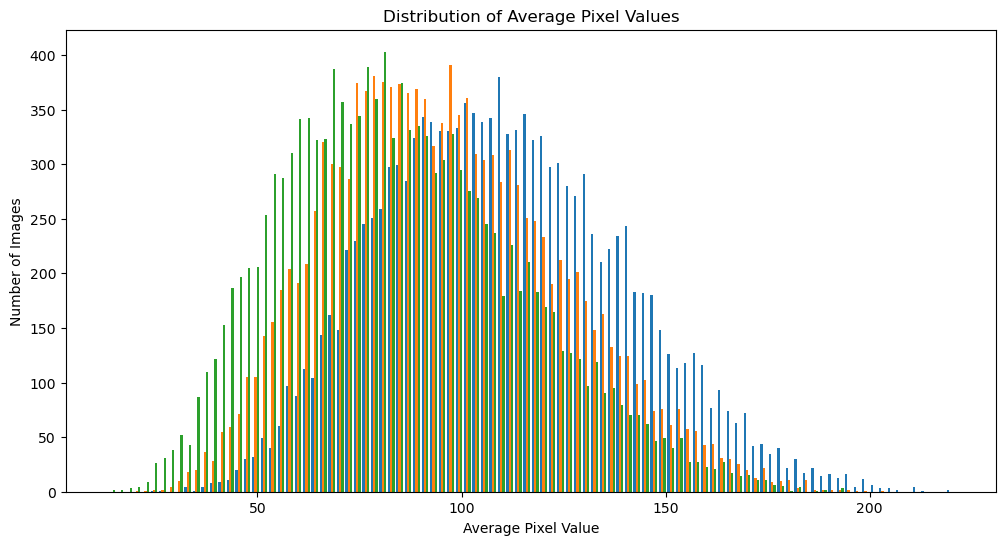

In [7]:
# Distribuition of Pixel Values

# code to skip cell


# Get the average pixel values for each image (Image In Gray Scale)
avg_pixel_values = np.mean(lfw_dataset['data'], axis=(1, 2))

# Plot the distribution of average pixel values
plt.figure(figsize=(12, 6))

plt.hist(avg_pixel_values, bins=100)

plt.xlabel('Average Pixel Value')

plt.ylabel('Number of Images')

plt.title('Distribution of Average Pixel Values')

plt.show()

### Plot Some Images

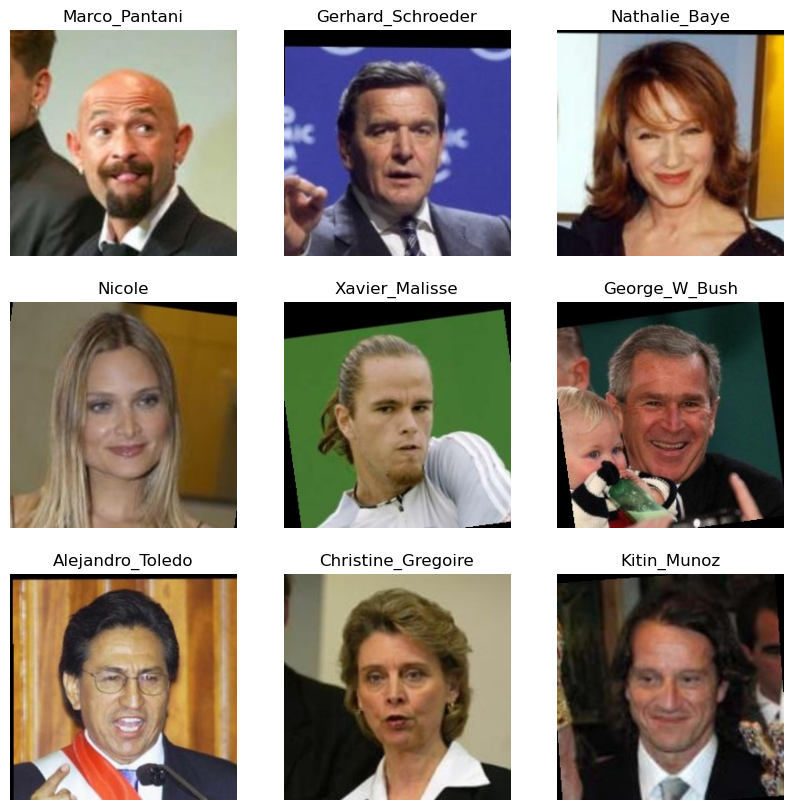

In [8]:
# Function to display a random set of images

def display_random_images(images, labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(labels[index])

    plt.show()

display_random_images(dataset['data'], dataset['target'], 3, 3, cmap='gray')

## Data Preprocessing

### Image Resizing

In [9]:
dataset = lfw_dataset.copy()
target_size = (100, 100)

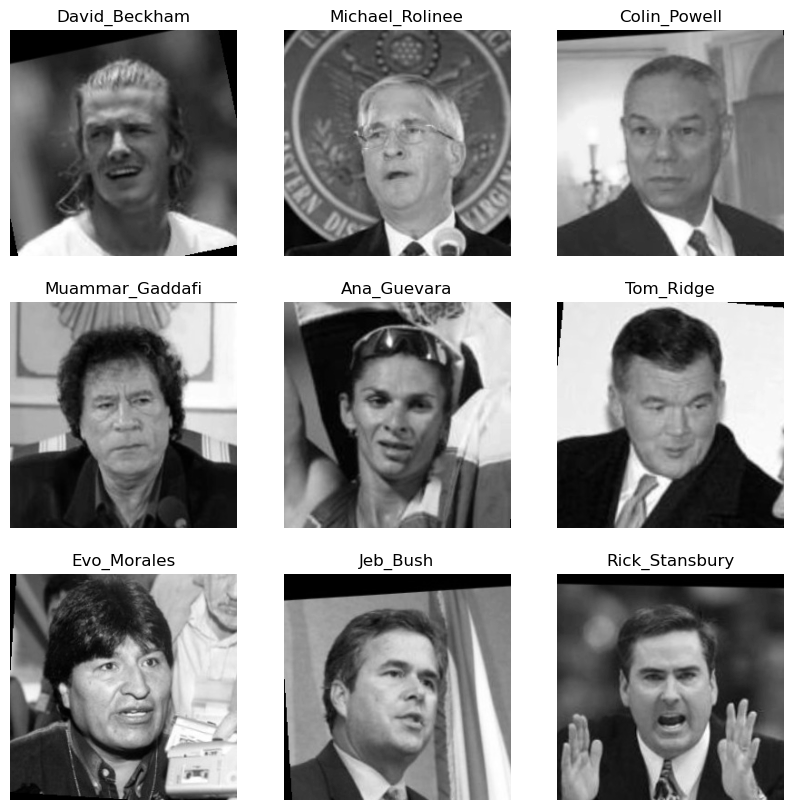

In [10]:
# Convert to gray scale
def gray_scale(images):
    if len(images.shape) == 3:
        print('Already gray scale')
        return images

    gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in images]
    return np.array(gray_images)

gray_images = gray_scale(dataset['data'])

display_random_images(gray_images, dataset['target'], 3, 3, cmap='gray')

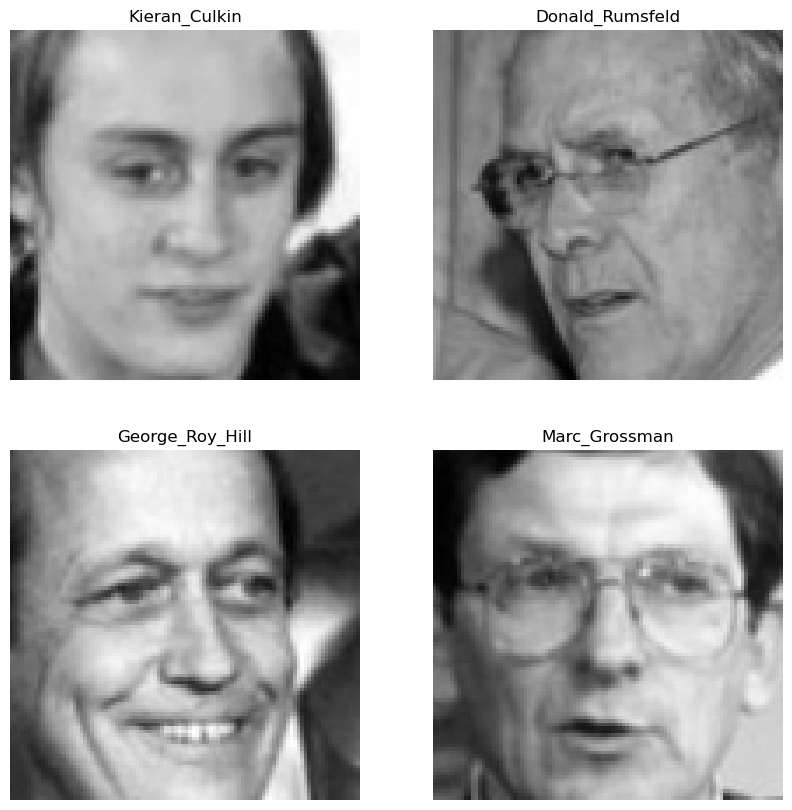

In [11]:
# Face detection 
from collections import defaultdict


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(images, labels):
    detected_faces = []
    updated_labels = []  # To store labels corresponding to detected faces
    label_counts = defaultdict(int)  # Dictionary to store the count of samples for each label

    for image, label in zip(images, labels):
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed
        # gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

        # Detect faces
        faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=5)

        if len(faces) == 1:
            (x, y, w, h) = faces[0]
            # Crop and resize the face to a fixed size (e.g., 100x100)
            face = cv2.resize(image[y:y+h, x:x+w], target_size)
            detected_faces.append(face)
            updated_labels.append(label)  # Append label for the detected face
            label_counts[label] += 1  # Increment the count for this label

    return np.array(detected_faces), np.array(updated_labels)

face_detect, updated_labels = detect_faces(gray_images, dataset['target'])
display_random_images(face_detect, updated_labels, 2, 2, cmap='gray')

In [24]:
dataset['data'] = face_detect
dataset['target'] = updated_labels

print("Shape of images:", dataset['data'].shape)
print("Shape of labels:", dataset['target'].shape)

Shape of images: (12413, 100, 100)
Shape of labels: (12413,)


Shape of resized images: (12413, 100, 100)


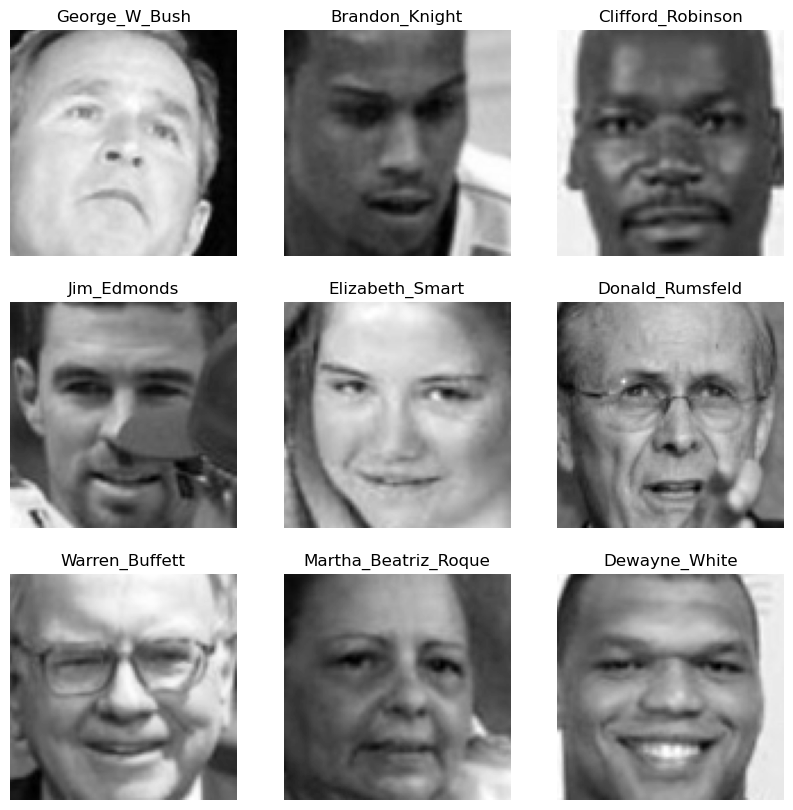

In [13]:
def resize_image(images, target_size):
    resized_images = [cv2.resize(image, target_size) for image in images]
    return np.array(resized_images)

resized_images = resize_image(dataset['data'], target_size)
print("Shape of resized images:", resized_images.shape)

# display_random_images function should work as expected with the resized images.
display_random_images(resized_images, dataset['target'], 3, 3, cmap='gray')

## Feature Extractions

In [14]:
def filter_dataset(dataset, min_faces_per_person):
    # Count the number of images for each person
    target_counts = Counter(dataset['target'])

    # Initialize the filtered dataset
    filtered_dataset = {
        'data': [],
        'target': [],
        'target_names': set()
    }

    # For each image and its corresponding label
    for image, label in zip(dataset['data'], dataset['target']):
        # If this person has at least min_faces_per_person images
        if target_counts[label] >= min_faces_per_person:
            # Add this image and label to the filtered dataset
            filtered_dataset['data'].append(image)
            filtered_dataset['target'].append(label)
            filtered_dataset['target_names'].add(label)

    filtered_dataset['data'] = np.array(filtered_dataset['data'])
    filtered_dataset['target'] = np.array(filtered_dataset['target'])
    filtered_dataset['target_names'] = np.array(list(filtered_dataset['target_names']))

    return filtered_dataset

dataset['data'] = resized_images.copy()

filtered_dataset = filter_dataset(dataset, min_faces_per_person=20)

In [15]:
filtered_dataset['data'].shape
filtered_dataset['target'].shape

print("Shape of images:", filtered_dataset['data'].shape)

Shape of images: (2734, 100, 100)


### TRAIN-TEST-SPLIT

In [16]:
X = filtered_dataset['data']
y = filtered_dataset['target']
original_shape = X.shape[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2187, 100, 100)
Shape of X_test: (547, 100, 100)
Shape of y_train: (2187,)
Shape of y_test: (547,)


In [17]:
import albumentations as A

# Augment for SVM with PCA
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Augment to increase the number of images for training
def augment_dataset(images, labels, augmentation_pipeline, label_threshold=35, n_augmentations=1):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        if np.sum(labels == label) < label_threshold:
            for _ in range(n_augmentations):
                augmented_image = augmentation_pipeline(image=image)['image']
                augmented_images.append(augmented_image)
                augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

augmented_images, augmented_labels = augment_dataset(X_train, y_train, augmentation_pipeline, label_threshold=30, n_augmentations=1)

X_train = np.concatenate([X_train, augmented_images])
y_train = np.concatenate([y_train, augmented_labels])

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (2936, 100, 100)
Shape of y_train: (2936,)


In [18]:
scaler = StandardScaler()
scaler.fit(X_train.reshape(-1, np.prod(original_shape)))

X_train = scaler.transform(X_train.reshape(-1, np.prod(original_shape)))
X_test = scaler.transform(X_test.reshape(-1, np.prod(original_shape)))

### Principal Component Analysis (Eigenfaces)

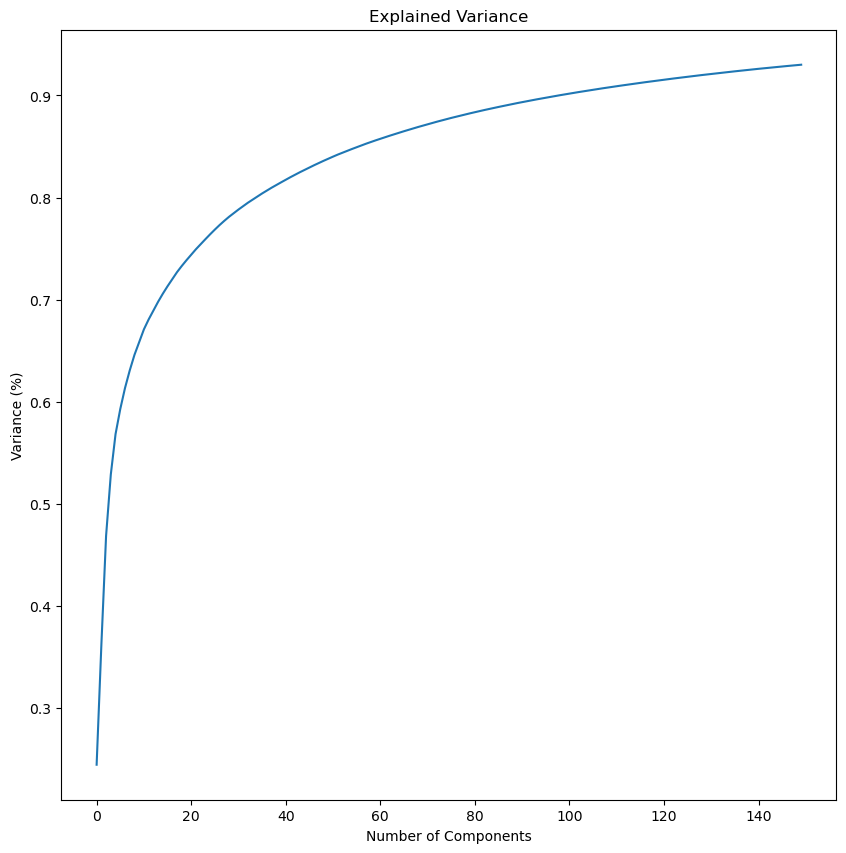

In [19]:
def pca_transform(X_train, X_test, n_components=None):
    pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca


X_train_pca, X_test_pca, pca = pca_transform(X_train, X_test, n_components=150)

# Function to plot the explained variance ratio
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

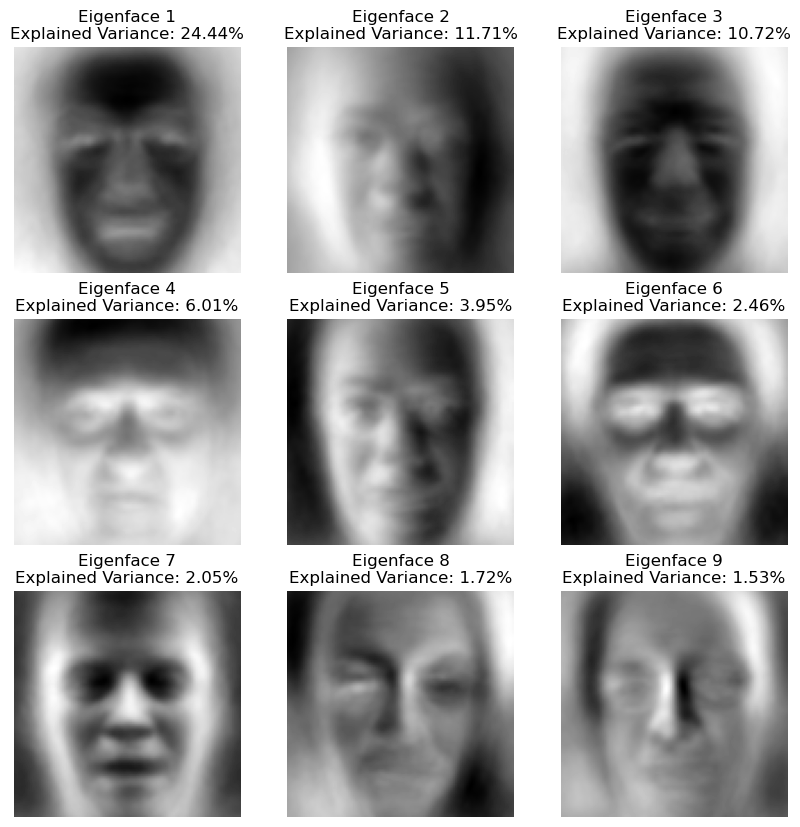

In [20]:
# Assuming pca is your PCA object and X_train is your training data
# Calculate explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the eigenfaces with information in the title
def plot_eigenfaces(components, h, w, rows, cols, explained_variance_ratio):
    plt.figure(figsize=(10, 10))

    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(components[i].reshape((h, w)), cmap='gray')
        plt.title(f'Eigenface {i + 1}\nExplained Variance: {explained_variance_ratio[i]*100:.2f}%')
        plt.axis('off')

    plt.show()

# Assuming your images have dimensions 80x80, adjust as needed
plot_eigenfaces(pca.components_, original_shape[0], original_shape[1], 3, 3, explained_variance_ratio)

## Model Training

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_clf = LDA()

lda_clf.fit(X_train_pca, y_train)

y_pred = lda_clf.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7641681901279708


In [21]:
svm_clf = SVC(kernel='rbf', C=1000, gamma=0.001, random_state=42, class_weight='balanced')

svm_clf.fit(X_train_pca, y_train)

y_pred = svm_clf.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7330895795246801
                           precision    recall  f1-score   support

         Alejandro_Toledo       0.50      0.29      0.36         7
             Alvaro_Uribe       0.50      0.57      0.53         7
          Amelie_Mauresmo       0.75      0.75      0.75         4
             Andre_Agassi       0.67      0.57      0.62         7
             Ariel_Sharon       0.73      0.79      0.76        14
    Arnold_Schwarzenegger       0.40      0.50      0.44         8
     Atal_Bihari_Vajpayee       1.00      0.75      0.86         4
             Bill_Clinton       0.60      0.60      0.60         5
             Colin_Powell       0.77      0.89      0.83        46
            David_Beckham       0.12      0.17      0.14         6
          Donald_Rumsfeld       0.78      0.82      0.80        22
         George_Robertson       1.00      0.50      0.67         4
            George_W_Bush       0.76      0.92      0.83        99
        Gerhard_Schroeder       

### Plot Prediction

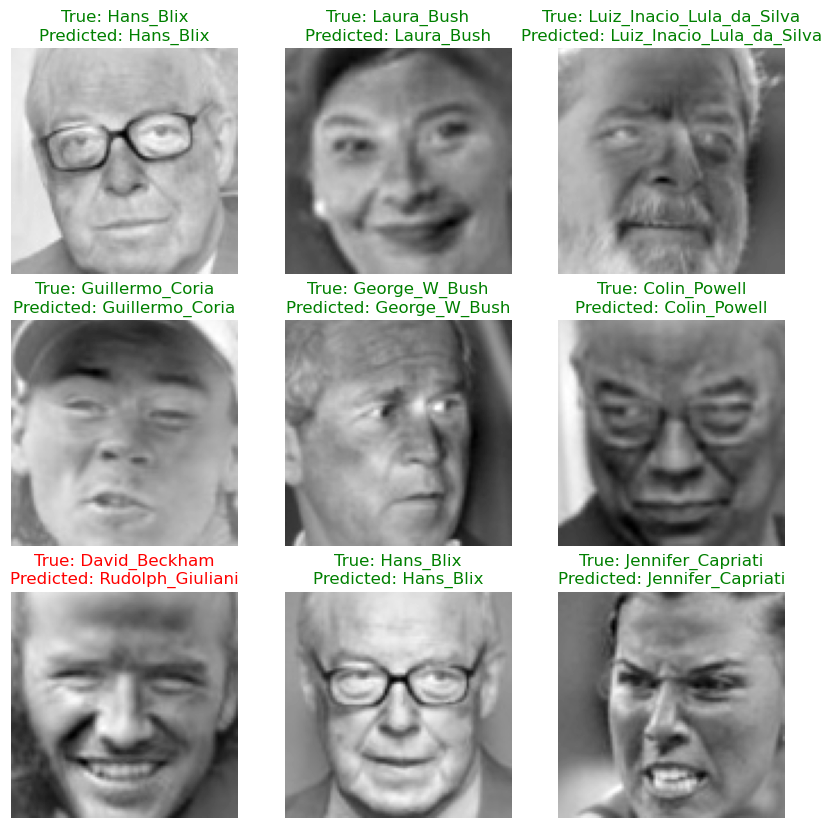

In [22]:
# Plot the predict results and its true label
def plot_predict_results(images, true_labels, pred_labels, rows, cols, cmap=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, cols * rows + 1):
        index = np.random.randint(len(images))
        plt.subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(images[index], cmap=cmap)
        plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}')

        # If the prediction is wrong, use red color
        if true_labels[index] != pred_labels[index]:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='red')
        else:
            plt.title(f'True: {true_labels[index]}\nPredicted: {pred_labels[index]}', color='green')

    plt.show()

# # Make predictions on the test set
y_pred = svm_clf.predict(X_test_pca)

plot_predict_results(X_test.reshape(-1, *original_shape), y_test, y_pred, 3, 3, cmap='gray')